# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd
import numpy as np
import re
import itertools


def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [4]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [5]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [6]:
round(data_reviews.isna().sum().to_frame('Porcentaje de valores faltantes')*100/len(data_reviews),3)

,Porcentaje de valores faltantes
username,0.000
hours,0.338
products,0.201
product_id,0.000
page_order,0.000
date,0.000
text,0.000
early_access,0.000
page,0.000
user_id,59.279


In [7]:
# Por lo pronto, procedemos a eliminar las últimas dos columnas que tienen valores faltantes en prácticamente todas las instancias.

data_reviews.drop(columns = ['found_funny', 'compensation'], inplace = True)

In [8]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
dtype: int64

**Games**

In [9]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [10]:
data_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN


In [11]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [12]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [13]:
round(data_games.isna().sum().to_frame('Porcentaje de valores faltantes')*100/len(data_games),3)

,Porcentaje de valores faltantes
publisher,25.057
genres,10.216
app_name,0.006
title,6.379
url,0.000
release_date,6.432
tags,0.507
discount_price,99.300
reviews_url,0.006
specs,2.085


### <font color='red'> Limpieza de datos <font>

In [14]:
data_games[data_games.app_name.isnull()]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
74,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,14.99,NaN,NaN,19.99,False,NaN,NaN,NaN,NaN
2580,NaN,"[Action, Indie]",NaN,NaN,http://store.steampowered.com/app/317160/_/,2014-08-26,"[Action, Indie]",NaN,http://steamcommunity.com/app/317160/reviews/?...,"[Single-player, Game demo]",NaN,False,317160,NaN,Positive,NaN


In [15]:
data_games.query('app_name=="Duet"')

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
4103,Kumobius,"[Action, Indie]",Duet,Duet,http://store.steampowered.com/app/292600/Duet/,2015-08-03,"[Indie, Action, Minimalist, Great Soundtrack, ...",NaN,http://steamcommunity.com/app/292600/reviews/?...,"[Single-player, Steam Achievements, Full contr...",4.99,False,292600,Kumobius,Very Positive,NaN


Cuando ingresamos al link del primer registro nulo en 'app_name' observamos que el juego no existe. Respecto al otro registro vacío, el juego ya se encuentra cargado en el dataset y con más información, por ello se decide eliminarlo.

In [16]:
data_games.dropna(subset=['app_name'], inplace=True)

In [17]:
data_games[data_games.id.isna()]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,NaN,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


*La url contiene el identificador del juego*

In [18]:
data_games.loc[30961, 'id'] = 200260

In [19]:
# Eliminamos las columnas que nos aportan poca información
# Título y app_name nos proveen la misma información, con la diferencia de que la primera contiene más de 2 mil valores faltantes

data_games.drop (columns = ['discount_price', 'title', 'early_access', 'developer', 'metascore', 'reviews_url', 'sentiment'], inplace = True)

In [20]:
data_games.head(2)

,publisher,genres,app_name,url,release_date,tags,specs,price,id
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,761140
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980


##### A continuación, se comprueba si contamos con juegos repetidos:

In [21]:
data_games[data_games.duplicated(subset=['id'], keep=False)].sort_values(by='id')

,publisher,genres,app_name,url,release_date,tags,specs,price,id
13894,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,612880
14573,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,612880


In [22]:
# Un solo juego se encuentra repetido, es el caso de Wolfestein II. Se elimina

data_games.drop_duplicates(subset=['id'], ignore_index=True, inplace=True)

In [23]:
data_games.isna().sum()

publisher       8050
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1376
id                 0
dtype: int64

In [24]:
round(data_games.isna().sum().to_frame('Porcentaje de valores faltantes')*100/len(data_games),3)

,Porcentaje de valores faltantes
publisher,25.053
genres,10.214
app_name,0.000
url,0.000
release_date,6.430
tags,0.504
specs,2.082
price,4.282
id,0.000


*Eliminamos todas las instancias que no tengan un género y especificaciones asignados, ya que o no pertenecen a un juego o  no se puede determinar esta información*

In [25]:
valores_faltantes_genres_specs = data_games.genres.isnull() & data_games.specs.isnull()
data_games = data_games[~valores_faltantes_genres_specs]
print(data_games.shape)

(31749, 9)


*Teniendo en cuenta que las columnas 'genres' y 'tags' nos proporcionan la misma información, se considera contruir una nueva a partir de la información obtenida en las primeras dos. Luego, se procede a eliminarlas y quedarnos con la creada*

In [26]:
# Aquí, reemplazaremos los valores faltantes por listas vacías. Esto facilitará la aplicación de funciones en estas tres columnas

for columna in ['genres', 'tags', 'specs']:
    data_games[columna].fillna({i: [] for i in data_games.index}, inplace=True)

In [27]:
# Creamos la columna categoría 

data_games['categories'] = data_games['genres'] + data_games['tags'] + data_games['specs']

# Evitamos que se repitan los mismos valores, ya que 'genres' y 'tags' suelen repetir la mayoría de su información
data_games['categories'] = [np.unique(cat) for cat in data_games.categories]

data_games['categories'] = [[re.sub(r'[^\w\s]', '', subcat).lower() for subcat in cat] 
                            for cat in data_games.categories]

*El siguiente paso requiere de una labor estricta manualmente, ya que debemos obtener todos los valores únicos presentes en el feature 'categories' y determinar, a partir de una exhaustiva búsqueda, si pertenecen o no a un juego*

In [28]:
np.unique(list(itertools.chain(*data_games.categories)))

array(['1980s', '1990s', '25d', '2d', '2d fighter', '360 video',
       '3d platformer', '3d vision', '4 player local', '4x', '6dof',
       'abstract', 'accounting', 'action', 'action rpg',
       'actionadventure', 'adventure', 'agriculture', 'aliens',
       'alternate history', 'america', 'animation  modeling',
       'animation amp modeling', 'anime', 'arcade', 'arena shooter',
       'artificial intelligence', 'assassin', 'asynchronous multiplayer',
       'atmospheric', 'audio production', 'base building',
       'based on a novel', 'basketball', 'batman', 'beat em up',
       'benchmark', 'bikes', 'blood', 'board game', 'bowling', 'building',
       'bullet hell', 'bullet time', 'capitalism', 'captions available',
       'card game', 'cartoon', 'cartoony', 'casual',
       'character action game', 'character customization', 'chess',
       'choices matter', 'choose your own adventure', 'cinematic',
       'city builder', 'classbased', 'classic', 'clicker', 'cold war',
       'c

In [29]:
# Alistamos aquellos valores que consideramos que no pertecen a un juego,
# que es lo que en definitiva nuestro sistema va a querer recomendarle al usuario


categorias_invalidas = ['photo editing', 'game development', 'documentary', 'video production', 'tutorial', 'software',
                      'movie', 'software training', 'soundtrack', 'utilities', 'accounting', 'downloadable content']

In [30]:
def tuplas(lista):
    return pd.DataFrame([game for game in data_games.itertuples() if np.isin(lista, game.categories).sum() > 0])

In [31]:
data_games = data_games[~data_games.id.isin(tuplas(categorias_invalidas).id)]

In [32]:
data_games.drop(['specs', 'tags'], inplace=True, axis=1)

In [33]:
data_games.shape

(17986, 8)

In [34]:
# Volvemos a colocar valores NaN en la columna de género en donde antes habíamos creado listas vacías

data_games['genres'] = data_games['genres'].apply(lambda x: np.nan if len(x) == 0 else x)

### Ahora analizamos el atributo precio y qúe tratamiento se le dará

In [35]:
a = [np.unique(price) for price in data_games.price]

np.unique(list(itertools.chain(*a)))

array(['0.49', '0.5', '0.89', '0.95', '0.98', '0.99', '1.0', '1.29',
       '1.5', '1.59', '1.87', '1.95', '1.99', '10.0', '10.96', '10.99',
       '11.15', '11.99', '119.99', '12.0', '12.89', '12.99', '124.99',
       '129.99', '13.37', '13.98', '13.99', '139.92', '14.95', '14.99',
       '149.99', '15.0', '15.99', '16.06', '16.99', '160.91', '17.99',
       '18.99', '189.96', '19.95', '19.98', '19.99', '199.99', '2.0',
       '2.3', '2.49', '2.89', '2.97', '2.99', '20.0', '20.99', '202.76',
       '21.99', '23.96', '23.99', '234.99', '24.99', '26.99', '29.99',
       '299.99', '3.0', '3.33', '3.49', '3.99', '31.99', '32.99', '320.0',
       '34.99', '39.99', '4.0', '4.49', '4.68', '4.99', '40.0', '44.98',
       '44.99', '49.99', '5.65', '5.99', '54.99', '59.95', '59.99',
       '6.66', '6.99', '61.99', '7.49', '7.99', '74.76', '771.71',
       '79.99', '8.98', '8.99', '87.94', '9.0', '9.69', '9.95', '9.98',
       '9.99', '99.99', 'Free', 'Free Demo', 'Free HITMAN™ Holiday Pack',
  

Como podemos observar, el atributo precio contiene valores flotantes y del tipo string. De este modo, se decide realizar una transformación de sus datos a variable categórica binaria (gratis/pagó). El valor 'Starting at $499.00' se pasará a 'pagó'

In [36]:
def transformar_precios(data):
    data['category_price'] = data.price.apply(lambda p: 'paid' if (type(p) == float or p.startswith('Starting')) else 'free')
    data.drop('price', axis=1, inplace=True)

In [37]:
transformar_precios(data_games)
data_games.head(2)

,publisher,genres,app_name,url,release_date,id,categories,category_price
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,761140,"[action, casual, indie, simulation, singleplay...",paid
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,643980,"[2d, board game, card game, character customiz...",free


### <font color='red'> Ahora continuamos con el preprocesamiento del dataframe que incluye los reviews <font>

In [38]:
data_reviews.head(2)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN


In [39]:
data_reviews.isnull().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
dtype: int64

In [40]:
# A continuación verificamos si un usuario ha realizado más de un review para el mismo videojuego

repeated_reviews = data_reviews[data_reviews.duplicated(subset=['username', 'product_id'], keep=False)].sort_values(by='username')

In [41]:
print('Reviews del mismo usuario al mismo videojuego:', repeated_reviews.shape)

Reviews del mismo usuario al mismo videojuego: (20343, 10)


In [42]:
repeated_reviews.head(4)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id
302434,!K3V0N!,76.7,143.0,201810,9,2014-11-14,"As far as first person shooters go, excellent....",False,1201,76561198048333835
302438,!K3V0N!,76.7,143.0,201810,2,2014-11-14,"As far as first person shooters go, excellent....",False,1202,76561198048333835
378384,"""JNK48""",24.9,29.0,433850,8,2017-01-29,so fun,True,2611,NaN
378394,"""JNK48""",24.9,29.0,433850,2,2017-01-29,so fun,True,2615,NaN


In [43]:
# Nos quedaremos con el último review realizado al mismo videojuego por el mismo usuario
unrepeated_reviews = data_reviews.sort_values(by='date', ascending=False).drop_duplicates(subset=['username', 'product_id'])

In [44]:
unrepeated_reviews.query('username=="!K3V0N!" & product_id=="201810"')

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id
302438,!K3V0N!,76.7,143.0,201810,2,2014-11-14,"As far as first person shooters go, excellent....",False,1202,76561198048333835


In [45]:
data_reviews = unrepeated_reviews.copy()

del repeated_reviews
del unrepeated_reviews

In [46]:
# Eliminamos aquellas columnas que no nos aportan información trascendente
data_reviews.drop(columns = ['products', 'page_order', 'early_access', 'page', 'user_id'], inplace = True)

In [47]:
data_reviews.head(3)

,username,hours,product_id,date,text
662506,PromiseVehicle,1.7,225840,2018-01-05,WOW BEST CO OP EVER NO GLITHCES I PLAY WITH MY...
356147,eye contact,27.1,550,2018-01-05,i was shooting black zombies and im ok with that
560549,TheUnseenPooper,479.4,552110,2018-01-05,Game says last year but this is just a port to...


In [48]:
data_reviews.isnull().sum()

username         0
hours         2632
product_id       0
date             0
text             0
dtype: int64

***Para los valores faltantes correspodientes a las horas de juego, se decide eliminar esas instancias ya que los valores faltantes representan una proporción insignificante respecto del total de datos***

In [49]:
round(data_reviews.hours.isnull().sum()/len(data_reviews)*100,2)

0.34

In [50]:
data_reviews.shape

(768903, 5)

In [51]:
data_reviews.dropna(subset= ['hours'], inplace =True)

In [52]:
data_reviews.shape

(766271, 5)

### Tratamiento de valores atípicos

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<AxesSubplot:xlabel='hours'>

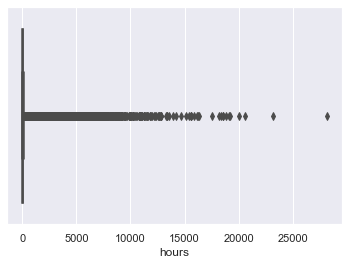

In [54]:
sns.boxplot(data= data_reviews, x= 'hours')

####        En esta instancia, eliminamos los outliers aplicando la técnica del rango intercuartílico, ya que es una de las más empleadas y efectivas en la materia.
*Como se desprende del gráfico, la presencia de estos valores atípicos no solo que distorsionan el análisis que se puede hacer de un determinado conjunto de valores, sino que tambíen su presencia afectaría de manera considerable el rendimiento de un modelo de machine learning.*

In [55]:
Q1 = data_reviews['hours'].quantile(0.25)
Q3 = data_reviews['hours'].quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR

out = (data_reviews['hours']<BI) | (data_reviews['hours']>BS)
print('Cantidad de valores eliminados: ', out.sum())
data_reviews = data_reviews[~out]

data_reviews.shape

Cantidad de valores eliminados:  108971


(657300, 5)

<AxesSubplot:xlabel='hours'>

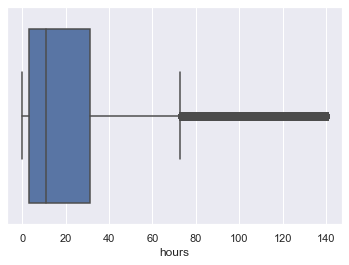

In [56]:
sns.boxplot(data= data_reviews, x= 'hours')

In [57]:
#Comprobamos si tenemos reviews con 0 horas de juego. En ese caso, debemos eliminarlos

data_reviews[data_reviews.hours == 0]

,username,hours,product_id,date,text
616932,General Jeff,0.0,355950,2017-11-26,"I have a black friend named jared, one time I ..."
541503,Stefan0,0.0,65720,2017-07-01,10/10
416596,Tore,0.0,8660,2017-06-10,"Great, fun and authentic racing sim if you don..."
541514,ThE GhOsT,0.0,65720,2017-02-03,10/10
682678,blokops,0.0,391270,2016-12-03,"Short ans simple ,"
...,...,...,...,...,...
329088,[NTA]-Sandata,0.0,2360,2010-11-21,Doom + Puzzle Items + RPG = Hexen. Three class...
225755,Aus,0.0,70,2010-11-20,A timeless classic. i can still play this and ...
487792,I'm that dude.,0.0,15710,2010-11-20,"If you played the first one, you know the deal..."
700024,Ivan Skodje,0.0,10180,2010-11-19,+1


In [58]:
data_reviews = data_reviews[(data_reviews.hours > 0)]
data_reviews.shape

(656843, 5)

In [59]:
# Eliminamos los juegos con menos de 2 reviews

print(data_reviews.shape)
data_reviews = data_reviews.groupby('product_id').filter(lambda x: len(x) >= 2)
data_reviews.product_id.value_counts()
print(data_reviews.shape)

(656843, 5)
(654149, 5)


## PARTE A - Análisis Exploratorio de Datos

In [60]:
print(f'La cantidad de usuarios únicos es: {len(data_reviews.username.value_counts())}')

La cantidad de usuarios únicos es: 460811


In [61]:
print("Cantidad mínima de videojuegos jugados por usuario:", data_reviews["username"].value_counts().min())
print("Cantidad máxima de videojuegos jugados por usuario:", data_reviews["username"].value_counts().max())
print("Promedio de videojuegos jugados por usuario:", data_reviews["username"].value_counts().mean())
print("Promedio de horas jugadas:", data_reviews["hours"].mean())

Cantidad mínima de videojuegos jugados por usuario: 1
Cantidad máxima de videojuegos jugados por usuario: 144
Promedio de videojuegos jugados por usuario: 1.4195602969547167
Promedio de horas jugadas: 23.491846047307266


In [62]:
# ¿Cuáles son los 10 juegos más populares?

for i in range(0,10):
    print(data_games[data_games.id==str(data_reviews.product_id.value_counts().index[i])].app_name.values)

['Team Fortress 2']
['Undertale']
['Portal 2']
['Life is Strange - Episode 1']
['Borderlands 2']
['Rust']
['Robocraft']
['Fallout 4']
['DayZ']
['Grand Theft Auto V']


In [63]:
amount_by_productId = data_reviews.groupby('product_id').product_id.count().reset_index(name='amount')

reviews_games_amount = pd.merge(amount_by_productId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='amount', ascending=False)
top10 = reviews_games_amount.head(10)

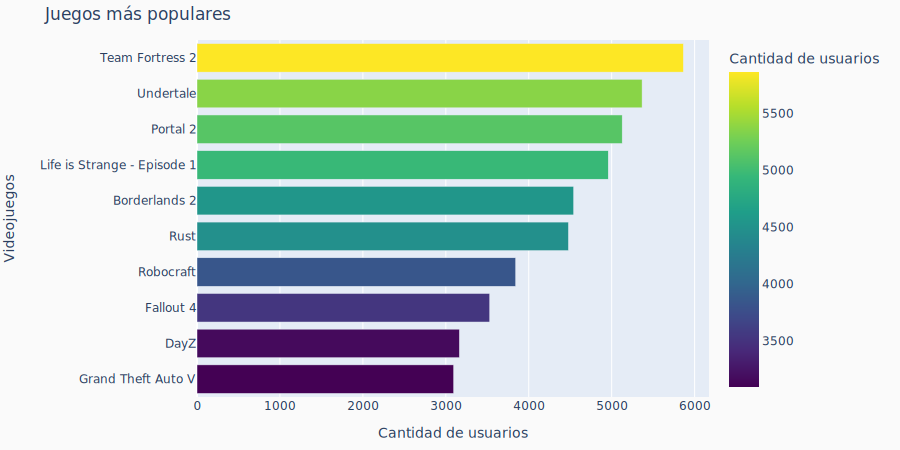

In [64]:
import plotly.express as px
from IPython.display import display, SVG

HOVER_DATA_COLUMNS = ['publisher', 'release_date', 'genres', 'category_price']

fig = px.bar(top10.sort_values(by='amount'), y='app_name', x='amount', color='amount', title='Juegos más populares',
             color_continuous_scale='viridis',
             labels={'app_name': 'Videojuegos',
                     "amount": 'Cantidad de usuarios'},
             hover_data=HOVER_DATA_COLUMNS,
             width=900,
             height=450
             )
fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=40, b=50)
                  )

display(SVG(fig.to_image(format='svg')))

In [65]:
# ¿Cuáles son los 10 juegos menos populares?

for i in range(0,10):
    print(data_games[data_games.id==str(data_reviews.product_id.value_counts(ascending=True).index[i])].app_name.values)

['Shades of Black']
['Defense of Egypt: Cleopatra Mission']
['Elder Chaos']
['Nary']
['Sun Dogs']
['Wacky Wheels HD']
['Cake Mania Collection']
["DROD RPG: Tendry's Tale"]
['Monsters Ate My Birthday Cake']
['BATTLE PIXELS']


In [66]:
# Usuarios que han realizado más reviews de juegos
data_reviews.username.value_counts()

Alex                   144
Chris                  121
Nick                   119
Matt                   108
Saint Aaron            107
                      ... 
Turtle.                  1
Jergon von Strangle      1
Thermidor                1
fatblue                  1
Mini Dew                 1
Name: username, Length: 460811, dtype: int64

Text(0.5, 1.0, 'Horas jugadas al hacer la review')

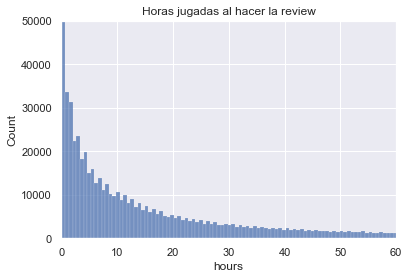

In [67]:
sns.histplot(data= data_reviews , x = 'hours')
plt.xlim([0,60])
plt.ylim([0,50000])
plt.title('Horas jugadas al hacer la review')

In [68]:
# Principales editores de los videojuegos

data_games.publisher.value_counts().to_frame('Cantidad de juegos por editor').head(10)

,Cantidad de juegos por editor
Big Fish Games,195
Strategy First,133
SEGA,126
Ubisoft,113
KISS ltd,101
THQ Nordic,96
Square Enix,90
Choice of Games,85
1C Company,77
Degica,67


In [69]:
hours_by_productId = data_reviews.groupby('product_id', as_index=False).hours.sum()

reviews_games_hours = pd.merge(hours_by_productId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='hours', ascending=False)

hours10 = reviews_games_hours.head(10).sort_values(by='hours')

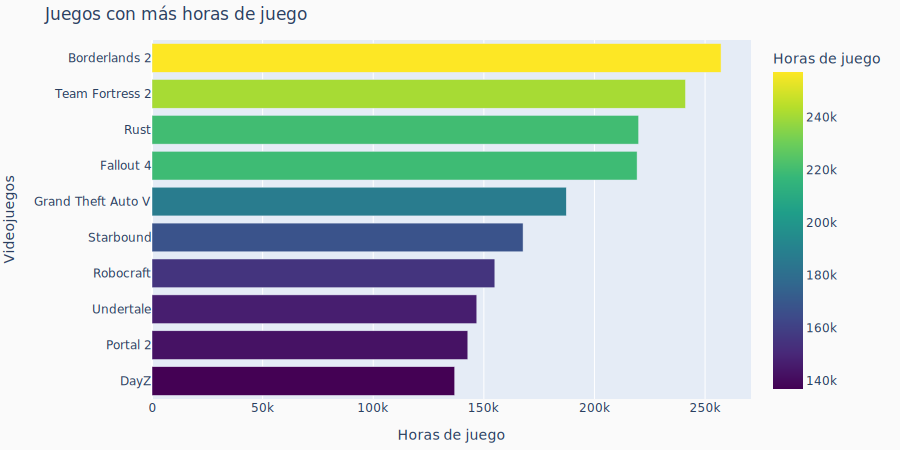

In [70]:
import plotly.express as px
from IPython.display import display, SVG

fig = px.bar(data_frame=hours10, y='app_name', x='hours', color='hours', title='Juegos con más horas de juego',
             color_continuous_scale='viridis',
             labels={'app_name': 'Videojuegos', "hours": 'Horas de juego'},
             hover_data=HOVER_DATA_COLUMNS,
             width=900,
             height=450
             )

fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=40, b=10)
                  )
#fig.show()
display(SVG(fig.to_image(format='svg')))

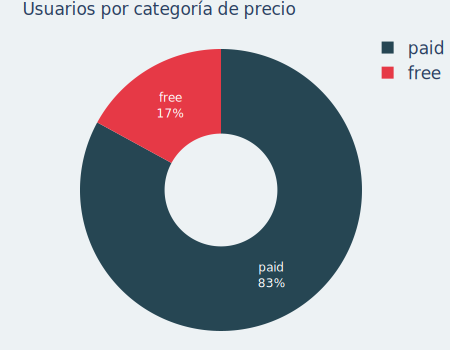

In [71]:
fig = px.pie(reviews_games_amount,
             names='category_price',
             values='amount',
             title='Usuarios por categoría de precio',
             width=450,
             height=350,
             hole=0.4,
             color_discrete_sequence=('#264653', '#E63946'),
             labels={'category_price': 'Tipo Precio', 'amount': 'Cantidad'}
             )

fig.update_layout(
    margin=dict(t=30, b=0),
    legend=dict(font=dict(size=17)),
    paper_bgcolor='#edf2f4'
)
fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show()
display(SVG(fig.to_image(format='svg')))

In [72]:
del hours_by_productId, reviews_games_hours, hours10

## Parte B - Modelo de Machine Learning

Se utilizará un filtro colaborativo basado en usuarios. Para ello, a la hora de estimar las calificaciones faltantes de un usuario en particular, lo que se hace es buscar a aquellos usuarios que tengan una mayor similitud y estimar esas calificaciones faltantes. Con ese objetivo, se realiza un promedio ponderado a partir de la semejanza entre los usuarios. Esta semejanza se determina con las calificaciones que ambos han realizado al mismo ítem. Cuanto más similares sean esas calificaciones, estamos en presencia de dos usuarios más semejantes entre sí.

La aplicación de este tipo de sistemas de recomendación encuentra su fundamento en que suelen tener un mejor desempeño que los filtros basados en contenido, por eso son ampliamente empleados. Pero tambíen cuentan con una delicada desventaja, que ya analizaremos más abajo.

Pero antes de eso, y considerando que no contamos con un rating específico de cada usuario respecto a los juegos -como sería de esperar en una clásica matriz de utilidad-, debemos adoptar algún critrerio que nos permita deducir si a un usuario le gustó o no un juego.
Esto lo haremos tomando como elemento disparador las horas de juego de cada usuario respecto a cada review realizada.
Si las horas jugadas se encuentran por encima de la mediana de ese usuario, diremos que el juego le gustó y lo denotaremos con un '1'.
Caso contrario -es decir, si no le gustó el juego- se computará con un '0'.

Al habernos finalmente inclinado por este paradigma dentro de los presentes en los sistemas de recomendación, mucho de los pasos que hemos realizados en el preprocesamiento del dataset de los juegos (data_games) veremos que quedarán sin uso cuando corramos nuestros modelos de machine learning. Esto se debe a que ya no nos interesa tanto saber acerca de los videojuegos en sí ni la información que podamos extraer sobre ellos -como, por ejemplo, su precio o género- sino que el foco ahora está más orientado en conocer sobre los usuarios que han realizado reviews de esos videojuegos. Nos interesa conocer las valoraciones que ellos tienen sobre los juegos, independientemente de los datos que estos juegos nos puedan brindar.

Ahora bien, en una primera instancia al emplear un filtro basado en contenidos nos encontraríamos con un gran problema: los nuevos usuarios, es decir quienes podrían catalogarse como Cold Start. Esta es una de las falencias de los filtros colaborativos, aquella delicada desventaja que enunciábamos supra.
Como en estos casos no sabemos cuáles son los ítems que le gustan al usuario, ya que todavía no ha consumido ninguno de nuestros productos, se procederá de la siguiente forma. A los nuevos usuarios se les recomendará automáticamente los videojuegos más populares. Luego, al ir consumiéndolos, serán tenidos en cuenta por el algoritmo recomendador para futuras recomendaciones.

In [73]:
import plotly.graph_objects as go

In [74]:
def plot_table(df):
    COLUMNS_FOR_USER = ['app_name', 'url', 'category_price']
    fig = go.Figure(go.Table(
        header=dict(values=['Juego', 'URL', 'Categoría de precio'],
                    fill_color='#ffd166',
                    font=dict(size=13)),
        cells=dict(values=np.vstack(df[COLUMNS_FOR_USER].values).T,
                   fill_color='#264653',
                   line_color='black',
                   line_width=.4,
                   font=dict(color='#f1faee'),
                   height=30),
        columnwidth=[1.5, 4, 1]))

    fig.update_layout(width=1000, height=370, margin=dict(t=10, b=0, l=0))
    return display(SVG(fig.to_image('svg')))

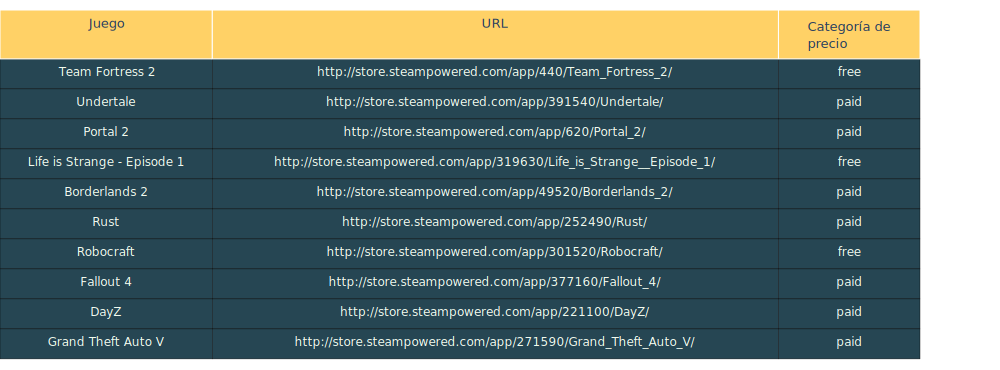

In [75]:
plot_table(reviews_games_amount.head(10))

#### Ahora crearemos un sistema que recomiende a los nuevos usuarios juegos basados en su popularidad

In [76]:
def get_popularity_recommendations(username, top=10):
    df_recs = reviews_games_amount[~reviews_games_amount.id.isin(
        data_reviews.query('username==@username').product_id)]
    plot_table(df_recs.head(top))

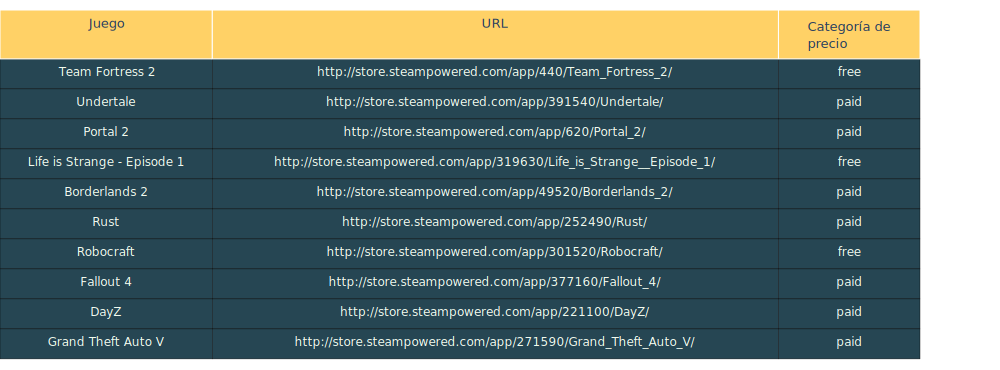

In [77]:
# Corroboramos seleccionando un usuario al azar
get_popularity_recommendations('Tore')

## Avanzamos para poder crear nuestro modelo Benchmark

In [78]:
# Creamos un nuevo atributo con las horas jugadas por el usuario al realizar la review
encod_type = data_reviews.groupby('username')['hours'].median()
data_reviews.loc[:, 'median_hours'] = data_reviews['username'].map(encod_type)

Text(0.5, 1.0, 'Distribución de la mediana de cada usuario al realizar las reviews')

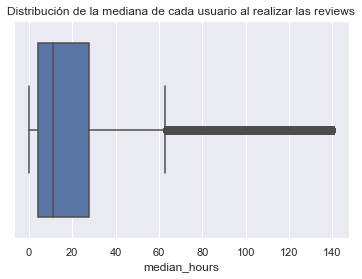

In [79]:
sns.boxplot(data = data_reviews, x = 'median_hours')
plt.title('Distribución de la mediana de cada usuario al realizar las reviews')

In [80]:
data_reviews['implicit_rating'] = np.where(data_reviews['hours']>=data_reviews['median_hours'], 1, 0)
data_reviews['implicit_rating'] = data_reviews['implicit_rating'].astype(np.uint8)

In [81]:
data_reviews.tail(5)

,username,hours,product_id,date,text,median_hours,implicit_rating
443589,GenEric,19.7,7670,2010-10-15,"In this game, you crash a plane into Ayn Rand'...",9.95,1
293349,Rogers,0.1,2100,2010-10-15,Dark Messiah is a wonderful action RPG that fe...,4.45,0
680094,daf,14.3,630,2010-10-15,"Free and fun, what more do you want?",0.40,1
121872,GenEric,0.2,340,2010-10-15,I'm stuck on the broken boat puzzle someone he...,9.95,0
574413,Sloth Bro,25.8,17300,2010-10-15,And you thought consoles have good graphics? W...,49.45,0


In [82]:
# Aquí nos quedamos solamente con las columnas que nos serán de utilidad

data_reviews= data_reviews[['username', 'product_id', 'implicit_rating',]]

# Reseteamos el índice

data_reviews = data_reviews.reset_index(drop=True)

In [83]:
data_reviews.head(3)

,username,product_id,implicit_rating
0,PromiseVehicle,225840,1
1,eye contact,550,1
2,LancerW,644930,1


In [84]:
data_reviews['product_id'] = data_reviews['product_id'].astype(np.uint32)
data_reviews.dtypes

username           object
product_id         uint32
implicit_rating     uint8
dtype: object

In [88]:
data_games.rename(columns={'id':'product_id'},inplace=True)
data_games['product_id'] = data_games['product_id'].astype(np.int32)
data_games.set_index('product_id',inplace=True)
data_games = data_games[['app_name']]

### Ahora sí, creamos nuestro modelo Benchmark de descomposición en valores singulares (SVD) con valores por defecto

In [101]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [102]:
reader = Reader(rating_scale = (0,1))

In [103]:
data=Dataset.load_from_df(data_reviews[['username','product_id','implicit_rating']], reader)

In [104]:
trainset, testset = train_test_split(data, test_size=.25)

In [167]:
#Para la medida de similitud utilizaremos la que se encuentra por defecto: ella es la similitud coseno.

from surprise import SVD


benchmark = SVD(random_state= 42)

In [168]:
# Entrenamos y predecimos

benchmark.fit(trainset)
predictions = benchmark.test(testset)

In [169]:
predictions[2]

Prediction(uid='Spearow', iid=236150, r_ui=1.0, est=0.8035825628326266, details={'was_impossible': False})

In [170]:
# Aquí realizamos una estimación para un usuario y un juego en particular

benchmark.predict('GenEric', 225)

Prediction(uid='GenEric', iid=225, r_ui=None, est=0.767871456190234, details={'was_impossible': False})

In [171]:
# Buscamos aquellos videojuegos que le gustaron al usuario

usuario = 'GenEric'
rating = 1  

df_user = data_reviews[(data_reviews['username'] == usuario) & (data_reviews['implicit_rating'] == rating)]
df_user = df_user.reset_index(drop=True)
df_user['app_name'] = data_games['app_name'].loc[df_user.product_id].values

df_user

,username,product_id,implicit_rating,app_name
0,GenEric,7670,1,BioShock™


In [172]:
# Hacemos lo mismo, pero para aquellos videojuegos que no le gustaron

rating = 0

df_user = data_reviews[(data_reviews['username'] == usuario) & (data_reviews['implicit_rating'] == rating)]
df_user = df_user.reset_index(drop=True)
df_user['app_name'] = data_games['app_name'].loc[df_user.product_id].values
df_user

,username,product_id,implicit_rating,app_name
0,GenEric,340,0,Half-Life 2: Lost Coast


In [173]:
# Verifimaos qué juegos jugó

usuario_jugados = data_reviews[data_reviews['username'] == usuario]
print(usuario_jugados.shape)
usuario_jugados

(2, 3)


,username,product_id,implicit_rating
654144,GenEric,7670,1
654147,GenEric,340,0


In [174]:
# Guardamos las recomendaciones

recomendaciones_usuario= data_games.copy()

# Suprimimos los juegos que ya jugó

recomendaciones_usuario.drop(usuario_jugados.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.shape
recomendaciones_usuario

,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge
...,...,...
17979,773640,Colony On Mars
17980,733530,LOGistICAL: South Africa
17981,610660,Russian Roads
17982,658870,EXIT 2 - Directions


In [175]:
# En esta instancia, realizamos las recomendaciones

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: benchmark.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario

,product_id,app_name,Estimate_Score
525,80200,Fate of the World,1.000000
13682,378930,Pesadelo - Regressão,1.000000
2501,321960,Might & Magic® Heroes® VII,1.000000
10427,545890,Breaking Wheel,1.000000
3414,477290,Magma Tsunami,1.000000
...,...,...,...
8985,613450,Please Knock on My Door,0.195388
2030,363410,Always The Same Blue Sky...,0.194540
876,248490,1953 - KGB Unleashed,0.171074
1519,329830,The Moon Sliver,0.155498


### Evaluación

Para evaluar nuestro modelo, utilizaremos como métrica de evaluación la raíz del error cuadrático medio (RMSE). La elección de esta medición radica en que, al elevar los errores al cuadrado antes de promediarlos, se le otorga un peso relativamente alto a los errores grandes. Y como en este caso lo que queremos es realizar recomendaciones, los errores grandes serían indeseables.

Asimismo, una métrica como el MAE que basa su esencia en los valores absolutos tienen el peligro de que hacen el error cada vez más grande a medida que se presentan más muestras. Y aquí contamos con un dataset con muchas instancias.
Por último, también se descarta el MSE ya que al elevar el error al cuadrado no tiene la misma magnitud ni unidades que la viariable a predecir. Es por esto que empleamos el RMSE que le aplica la raíz a la fórmula.

In [178]:
from surprise import accuracy
error_1 = accuracy.rmse(predictions)
error_1

RMSE: 0.3892


0.38922780335538804

### Optimización de hiperparámetros

***Ahora empezamos a construir modelos más avanzados, modificando hiperparámetros y evaluando***

In [179]:
from surprise.model_selection import cross_validate

#Primero realizamos una búsqueda manual con valores arbitrarios a ver qué sucede con el RMSE
rmse_test_means = []
factores = [1,2,4,8,10,12,15,20]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.3866  0.3878  0.3878  0.3874  0.0006  
Fit time          6.22    6.03    6.16    6.13    0.08    
Test time         1.64    1.08    1.58    1.43    0.25    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.3881  0.3872  0.3867  0.3873  0.0006  
Fit time          6.39    6.18    6.28    6.28    0.08    
Test time         1.13    1.07    1.58    1.26    0.23    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.3880  0.3865  0.3877  0.3874  0.0007  
Fit time          6.69    6.52    6.55    6.58    0.07    
Test time         1.09    1.53    1.60    1.41    0.23    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

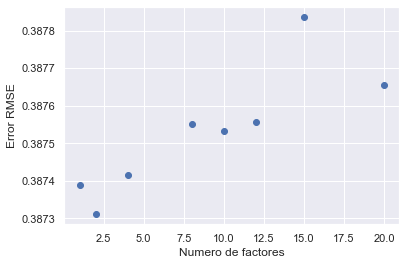

In [180]:
# Graficamos

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [181]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [2],'n_epochs': [10,20,30], 'lr_all': [0.002, 0.005, 0.008],
              'reg_all': [0.01, 0.02,0.03], 'random_state' : [42]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'],cv=2, n_jobs = -1)
gs.fit(data)

In [182]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.3850999893162239
{'n_factors': 2, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.03, 'random_state': 42}


In [183]:
error_2 = gs.best_score['rmse']

### Ahora empleramos otra técnica de reducción de dimensionalidad que consiste en una extensión de la que veníamos utilizando, conocida como SVD ++

In [184]:
from surprise import SVDpp
algo2 = SVDpp(random_state = 42)

In [185]:
algo2.fit(trainset)

In [186]:
predictions = algo2.test(testset)

In [187]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.3937


0.39372295552599834

In [188]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,5,10]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo2 = SVDpp(n_factors=factor)
    cv = cross_validate(algo2, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.3892  0.3893  0.3898  0.3894  0.0003  
Fit time          30.98   31.25   31.05   31.09   0.11    
Test time         1.93    1.88    2.52    2.11    0.29    

Número de Factores: 2
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.3894  0.3893  0.3896  0.3895  0.0001  
Fit time          31.84   31.94   31.74   31.84   0.08    
Test time         1.96    1.90    2.47    2.11    0.26    

Número de Factores: 4
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.3906  0.3896  0.3888  0.3897  0.0007  
Fit time          33.06   32.77   32.43   32.75   0.26    
Test time         1.95    2.50    2.48    2.31    0.25    

Número de Factores: 5
Evaluating RMSE of algorithm SVDpp on 3 split(s

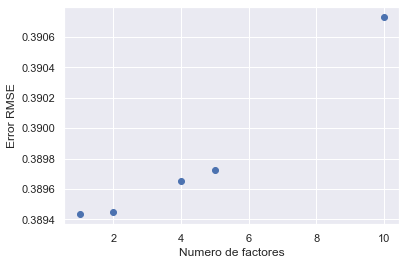

In [189]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [190]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [1],'n_epochs': [10,20,30], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.01, 0.02,0.03 ]}

gs2 = GridSearchCV(SVDpp, param_grid, measures=['rmse'],cv=2, n_jobs = -1)
gs2.fit(data)

In [191]:
print(gs2.best_score['rmse'])
print(gs2.best_params['rmse'])

0.3850161799077501
{'n_factors': 1, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.03}


In [192]:
error_3= gs2.best_score['rmse']

(0.384, 0.389)

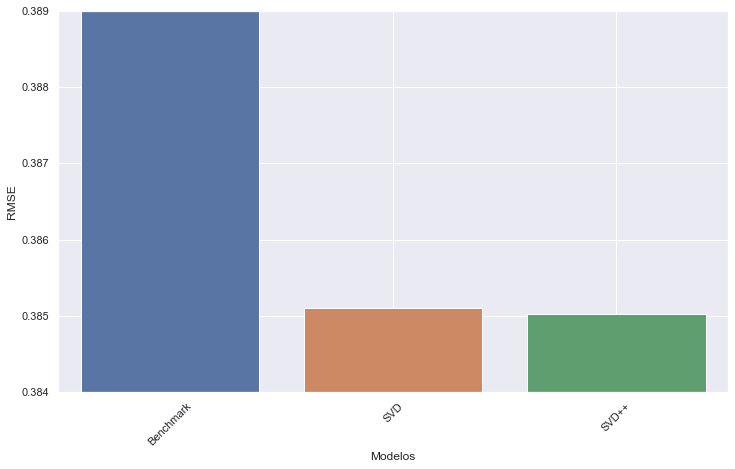

In [216]:
plt.figure(figsize=(12,7))

errores = {
    'Modelos': ['Benchmark', 'SVD', 'SVD++'],
    
    'RMSE': [error_1 ,error_2, error_3]}

tabla_errores = pd.DataFrame(errores, columns = ['Modelos', 'RMSE'])

sns.barplot(x = 'Modelos', y = 'RMSE', data = tabla_errores)
plt.grid('y')
plt.xticks(rotation = 45)
plt.ylim([0.384,0.389])

#### <font color='green'> **CONCLUSIÓN** <font>

Luego de crear y analizar los distintos modelos que fuimos viendo, llegamos a la conclusión de que el mejor modelo para realizar recomendaciones es un **SVD ++** con los siguientes hiperparámtros:

+ n_factors: 1
+ n_epoch': 20
+ lr_all: 0.002
+ reg_all: 0.01


Si bien la mejoría en su performance respecto a nuestro modelo benchmark y al modelo SVD no es significativa ni sustancial, consideramos que así y todo los resultados obtenidos son bastante satisfactorios.
El punto a tener en cuenta yacería en el costo computacional que se esté dispuesto a asumir para obtener esa leve mejoría, pero mejoría al fin, en el desempeño.
Para este caso, se considera que el beneficio obtenido en el rendimiento es mayor que el costo a pagar para obtener este performance.

## PARTE C - INVESTIGACIÓN

<font color='blue'>***OPTIMIZACIÓN DEL TIPO DE DATOS***</font>

En este apartado, al ejecutar el siguiente código se presentaron problemas en la sección A respectiva al Análisis Exploratirio. Ello se dio al momento de crear las listas de los juegos más y menos populares y al realizar la consulta sobre el promedio de las horas jugadas por los usuarios. En el primer caso, se obtenían listas vacías como respuesta.


data_reviews['product_id'] = data_reviews['product_id'].astype(np.uint32)

data_reviews['hours'] = data_reviews['hours'].astype(np.float16)

data_games['id'] = data_games['id'].astype(np.int32)


<font color='blue'>***INCORPORAR ANÁLISIS DE SENTIMIENTO***</font>

Esta técnica podría ser de gran utilidad al momento de considerar el atributo 'sentiment' del dataset de los videojuegos. Así, podríamos obtener un estimador bastante fidedigno de la valoración que los usuarios realizan de los videojuegos. Esto podría ser un elemento a considerar si se realiza un filtro basado en contenido o  uno colaborativo basado en ítems (casualmente los dos paradigmas restantes que no fueron empleados en este proyecto).

<font color='blue'>***INCORPORAR PROCESAMIENTO DE LENGUAJE NATURAL***</font>

Con esta herramienta estaríamos contando con un gran potencial, ya que nos permitiría cuantificar la valoración que los usuarios tienen de los videojuegos a los que le han hecho una review. Aplicando esta estrategia en el dataset de los reviews -en el atributo 'text'-, podría avanzarse en la elaboración de una matriz de utilidad.

<font color='blue'>***REALIZAR UN RATING SEGÚN LA CANTIDAD DE HORAS JUGADAS POR EL USUARIO PARA LA CALIFICACIÓN DEL VIDEOJUEGO***</font>

Acá lo que se buscaría es ampliar el abanico de posibilidades, para que en vez de obtener un '1' o un '0' como hicimos a raíz de la técnica de la mediana (para determinar si al usuario le gustó o no el videojuego) se pueda ponderar más exhaustivamente la satisfacción del usuario con ese videojuego aplicando una escala. De esta manera, se espera que mejore la precisión de nuestras predicciones y se reduzca el RMSE.